<a href="https://colab.research.google.com/github/Yoni-Git/Better-Organized/blob/master/Homework2_7401577e_0177_4fe1_a94e_0ada500332eb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total time (seconds): {'LogReg': 0.15971040725708008, 'GD-SquareSigmoid': 0.9702200889587402, 'SGD-SquareSigmoid': 2.298870325088501}


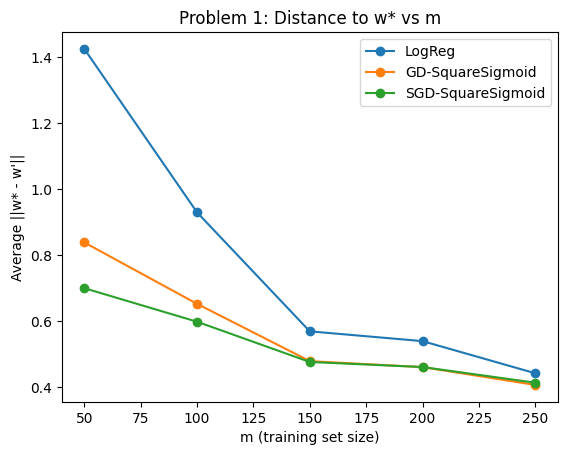

Saved plot to: q1_distance_vs_m.png


In [4]:
# q1.py
import numpy as np
import time
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, List, Dict
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Utilities
# -----------------------------

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

def generate_w_star(d: int, rng: np.random.Generator) -> np.ndarray:
    """Sample w* ~ N(0, I) and normalize to ||w*||_2 = 1."""
    w = rng.normal(size=d)
    n = np.linalg.norm(w)
    while n == 0.0:
        w = rng.normal(size=d)
        n = np.linalg.norm(w)
    return w / n

def generate_dataset(w_star: np.ndarray, m: int, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    """Sample X ~ N(0, I) and y ~ Bernoulli(sigmoid(w*^T x))."""
    X = rng.normal(size=(m, w_star.shape[0]))
    z = X @ w_star
    p = sigmoid(z)
    y = (rng.uniform(size=m) <= p).astype(int)
    return X, y

# -----------------------------
# Algorithms
# -----------------------------

@dataclass
class GDConfig:
    lr: float = 0.1
    epochs: int = 600
    tol: float = 1e-8

@dataclass
class SGDConfig:
    lr0: float = 0.5
    epochs: int = 20
    schedule: str = "sqrt"  # "sqrt" or "constant"

def grad_square_sigmoid_batch(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
    """
    Gradient of (1/(2m)) * sum_i (sigmoid(x_i·w) - y_i)^2 with respect to w.
    """
    m = X.shape[0]
    s = sigmoid(X @ w)
    coeff = (s - y) * s * (1.0 - s)
    g = X.T @ coeff
    return g / m

def train_gd_square_sigmoid(X: np.ndarray, y: np.ndarray, cfg: GDConfig) -> np.ndarray:
    """Batch GD on 0.5 * mean (sigmoid(Xw) - y)^2."""
    w = np.zeros(X.shape[1], dtype=float)
    last_obj = None
    for ep in range(cfg.epochs):
        g = grad_square_sigmoid_batch(X, y, w)
        w = w - cfg.lr * g
        if ep % 60 == 0 or ep == cfg.epochs - 1:
            s = sigmoid(X @ w)
            obj = 0.5 * np.mean((s - y) ** 2)
            if last_obj is not None and abs(last_obj - obj) < cfg.tol:
                break
            last_obj = obj
    return w

def train_sgd_square_sigmoid(X: np.ndarray, y: np.ndarray, cfg: SGDConfig, rng: np.random.Generator) -> np.ndarray:
    """SGD on 0.5 * mean (sigmoid(Xw) - y)^2 with sqrt step-size decay."""
    w = np.zeros(X.shape[1], dtype=float)
    m = X.shape[0]
    idx = np.arange(m)
    t = 0
    for ep in range(cfg.epochs):
        rng.shuffle(idx)
        for i in idx:
            t += 1
            s = sigmoid(X[i] @ w)
            grad = (s - y[i]) * s * (1.0 - s) * X[i]
            eta = cfg.lr0 / np.sqrt(t) if cfg.schedule == "sqrt" else cfg.lr0
            w = w - eta * grad
    return w

def train_logistic_regression(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Logistic Regression without regularization when possible.
    Fallback to very weak L2 if the environment rejects penalty=None.
    """
    try:
        clf = LogisticRegression(
            penalty=None,        # preferred when supported
            fit_intercept=False,
            solver="lbfgs",
            max_iter=2000
        )
        clf.fit(X, y)
    except Exception:
        clf = LogisticRegression(
            penalty="l2",        # practical "no reg" via huge C
            C=1e9,
            fit_intercept=False,
            solver="lbfgs",
            max_iter=2000
        )
        clf.fit(X, y)
    return clf.coef_.ravel()

# -----------------------------
# Experiment Runner
# -----------------------------

def run_experiment(
    d: int = 10,
    m_values: List[int] = [50, 100, 150, 200, 250],
    repeats: int = 10,
    gd_cfg: GDConfig = GDConfig(),
    sgd_cfg: SGDConfig = SGDConfig(),
    seed: int = 42
) -> Dict:
    """
    For each m, repeat:
      - sample fresh w* and dataset
      - train (LogReg, GD, SGD)
      - record ||w* - w'|| for each
    Return averages over repeats for each m.
    """
    rng = np.random.default_rng(seed)
    alg_names = ["LogReg", "GD-SquareSigmoid", "SGD-SquareSigmoid"]
    distances = {alg: [] for alg in alg_names}
    total_time = {alg: 0.0 for alg in alg_names}

    for m in m_values:
        dists_for_m = {alg: [] for alg in alg_names}
        for _ in range(repeats):
            # Fresh w* and fresh data each repeat
            w_star = generate_w_star(d, rng)
            X, y = generate_dataset(w_star, m, rng)

            t0 = time.time()
            w_lr = train_logistic_regression(X, y)
            total_time["LogReg"] += time.time() - t0
            dists_for_m["LogReg"].append(float(np.linalg.norm(w_star - w_lr)))

            t0 = time.time()
            w_gd = train_gd_square_sigmoid(X, y, gd_cfg)
            total_time["GD-SquareSigmoid"] += time.time() - t0
            dists_for_m["GD-SquareSigmoid"].append(float(np.linalg.norm(w_star - w_gd)))

            t0 = time.time()
            w_sgd = train_sgd_square_sigmoid(X, y, sgd_cfg, rng)
            total_time["SGD-SquareSigmoid"] += time.time() - t0
            dists_for_m["SGD-SquareSigmoid"].append(float(np.linalg.norm(w_star - w_sgd)))

        for alg in alg_names:
            distances[alg].append(float(np.mean(dists_for_m[alg])))

    return {"m_values": m_values, "avg_distances": distances, "total_time": total_time}

def plot_results(res: Dict, out_path: str = "q1_distance_vs_m.png", show: bool = True) -> None:
    plt.figure()
    for alg, ys in res["avg_distances"].items():
        plt.plot(res["m_values"], ys, marker="o", label=alg)
    plt.xlabel("m (training set size)")
    plt.ylabel("Average ||w* - w'||")
    plt.title("Problem 1: Distance to w* vs m")
    plt.legend()
    plt.savefig(out_path, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    print(f"Saved plot to: {out_path}")

# -----------------------------
# Script entry
# -----------------------------
if __name__ == "__main__":
    res = run_experiment()
    print("Total time (seconds):", res["total_time"])
    plot_results(res)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_breast_cancer

def run_adaboost_depth_sweep(depths = [1,2,3,4,5], n_estimators=50, cv_folds=10, seed=123):
    data = load_breast_cancer()
    X, y = data.data, data.target
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=seed)
    acc_means, acc_stds = [], []
    for d in depths:
        dt = DecisionTreeClassifier(max_depth=d, random_state=seed)
        try:
            clf = AdaBoostClassifier(estimator=dt, n_estimators=n_estimators, random_state=seed)
        except TypeError:
            clf = AdaBoostClassifier(base_estimator=dt, n_estimators=n_estimators, random_state=seed)
        scores = cross_val_score(clf, X, y, cv=kf, scoring="accuracy")
        acc_means.append(float(np.mean(scores)))
        acc_stds.append(float(np.std(scores)))
    return {"depths": depths, "acc_means": acc_means, "acc_stds": acc_stds}

def plot_acc_vs_depth(res: dict, out_path: str = "q2_adaboost_accuracy_vs_depth.png") -> None:
    plt.figure()
    plt.plot(res["depths"], res["acc_means"], marker="o")
    plt.xlabel("Decision tree depth (base learner)")
    plt.ylabel("10-fold CV accuracy")
    plt.title("Problem 2: AdaBoost accuracy vs base tree depth")
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()
    print(f"Saved plot to: {out_path}")

if __name__ == "__main__":
    res = run_adaboost_depth_sweep()
    print("Per-depth (mean, std):")
    for d, m, s in zip(res["depths"], res["acc_means"], res["acc_stds"]):
        print(f" depth={d}: mean={m:.4f}, std={s:.4f}")
    plot_acc_vs_depth(res)


Per-depth (mean, std):
 depth=1: mean=0.9665, std=0.0218
 depth=2: mean=0.9595, std=0.0297
 depth=3: mean=0.9701, std=0.0224
 depth=4: mean=0.9683, std=0.0249
 depth=5: mean=0.9683, std=0.0192
Saved plot to: q2_adaboost_accuracy_vs_depth.png
